In [ ]:
"""
Created on Thu Dec 07 10:42 2023

Trying to reproduce figures from Katherine

Author: @claraburgard
"""

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean

import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
import seaborn as sns

from basal_melt_NEMO.constants import *
import basal_melt_NEMO.figure_functions as figf

In [2]:
sns.set_context('paper')

In [3]:
%matplotlib qt5

QStandardPaths: error creating runtime directory '/run/user/2784' (Permission denied)


READ IN DATA

In [4]:
inputpath_closed='/data/cdelaver/n42tm21/'
inputpath_open='/data/cdelaver/n42openc/'

In [5]:
T_grid_vars_closed = xr.open_dataset(inputpath_closed + 'n42tm21_00910101_01001231_1Y_grid_T.nc').mean('time_counter')
T_grid_vars_open = xr.open_dataset(inputpath_open + 'n42openc_00910101_01001231_1Y_grid_T.nc').mean('time_counter')
T_grid_vars_open = T_grid_vars_open.where(T_grid_vars_open['so'] > 0)

In [7]:
lon = T_grid_vars_open.nav_lon
lat = T_grid_vars_open.nav_lat

In [20]:
T_grid_vars_closed['area']

<xarray.DataArray 'area' (y: 331, x: 360)>
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)
Coordinates:
    nav_lat  (y, x) float32 ...
    nav_lon  (y, x) float32 ...
Dimensions without coordinates: y, x

In [31]:
# GLOBAL STUFF
print('Mean SST closed',T_grid_vars_closed['thetao'].weighted(T_grid_vars_closed['area'].fillna(0)).mean().values)
print('Mean SST open',T_grid_vars_open['thetao'].weighted(T_grid_vars_open['area'].fillna(0)).mean().values)

Mean SST closed 10.835891445178225
Mean SST open 10.828040709782305


In [32]:
print('Mean SSS closed',T_grid_vars_closed['so'].weighted(T_grid_vars_closed['area'].fillna(0)).mean().values)
print('Mean SSS open',T_grid_vars_open['so'].weighted(T_grid_vars_open['area'].fillna(0)).mean().values)

Mean SSS closed 34.89923442797015
Mean SSS open 34.90338689645831


In [8]:
mask_Ant = lat < -50
mask_Weddell = (lon <= 5) & (lon >= -65.) & (lat >= -78.) & (lat <= -60.)
mask_Ross = ((lon <= -120) | (lon >= 150)) & (lat >= -87.) & (lat <= -65.)

In [9]:
# ANT
T_grid_vars_closed_Ant = T_grid_vars_closed.where(mask_Ant, drop=True)
T_grid_vars_open_Ant = T_grid_vars_open.where(mask_Ant, drop=True)
lon_Ant = T_grid_vars_open_Ant['nav_lon']
lat_Ant = T_grid_vars_open_Ant['nav_lat']

In [10]:
# Weddell
T_grid_vars_open_Wed = T_grid_vars_open.where(mask_Weddell, drop=True)
T_grid_vars_closed_Wed = T_grid_vars_closed.where(mask_Weddell, drop=True)
lon_Wed = T_grid_vars_open_Wed['nav_lon']
lat_Wed = T_grid_vars_open_Wed['nav_lat']

In [13]:
# Ross
T_grid_vars_open_Ross = T_grid_vars_open.where(mask_Ross, drop=True)
T_grid_vars_closed_Ross = T_grid_vars_closed.where(mask_Ross, drop=True)
lon_Ross = T_grid_vars_open_Ross['nav_lon']
lat_Ross = T_grid_vars_open_Ross['nav_lat']

In [ ]:
T_grid_vars_closed_FRIS 

In [ ]:
T_grid_vars_open_FRIS['thetao'].isel(deptht=0).plot()

In [14]:
def maps_compare3(lon,lat,ref,modif,name,cmap,region,legend,lat_lim=-50):
    
    f = plt.figure(figsize=(8.25*3,8.25))
    #f = plt.figure()
    #f.suptitle(str(time_in.values)[0:16],fontsize=22)

    if region == 'global':
        proj = ccrs.Mollweide(central_longitude=0)
        wrap_ref = ref
        wrap_lon = lon
        wrap_modif = modif
        
    elif region == 'Ant':
        proj = ccrs.SouthPolarStereo(central_longitude=0)
        wrap_ref, wrap_lon = ref, lon #add_cyclic_point(ref.values,coord=lon,axis=1)
        wrap_modif, wrap_lon = modif, lon #add_cyclic_point(modif.values,coord=lon,axis=1)

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpl.path.Path(verts * radius + center)   

        extent = [-180, 180, -90, -50]
    
    elif region == 'Weddell':
        proj = ccrs.SouthPolarStereo(central_longitude=-32)
        wrap_ref, wrap_lon = ref, lon #add_cyclic_point(ref.values,coord=lon,axis=1)
        wrap_modif, wrap_lon = modif, lon #add_cyclic_point(modif.values,coord=lon,axis=1)

        extent = [-63, 0, -78, -64]
    
    elif region == 'Ross':
        cm = 180
        proj = ccrs.SouthPolarStereo(central_longitude=cm)
        wrap_ref, wrap_lon = ref, lon #add_cyclic_point(ref.values,coord=lon,axis=1)
        wrap_modif, wrap_lon = modif, lon #add_cyclic_point(modif.values,coord=lon,axis=1)
        minlon = -20 + cm
        maxlon = +50 + cm
        extent = [minlon, maxlon, -85, -70]
        
    #### REFERENCE
    ax1 = plt.subplot(1, 3, 1, projection=proj)
    abso0 = ax1.pcolormesh(wrap_lon,lat,wrap_ref,transform=ccrs.PlateCarree(),cmap=cmap,rasterized=True)
    ax1.coastlines(resolution='110m', linewidth=0.5)
    ax1.set_extent(extent, crs=ccrs.PlateCarree())

    if region == 'global':
        ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    elif region == 'Ant':
        ax1.set_boundary(circle, transform=ax1.transAxes)

    if legend=='yes':
        cbar = f.colorbar(abso0, ax=ax1, shrink=0.3,orientation='vertical',extend='both')
        cbar.set_label(name,rotation=90)  

    #### MODIFICATION
    ax2 = plt.subplot(1, 3, 2, projection=proj)
    ax2.coastlines(resolution='110m', linewidth=0.5)
    abso = ax2.pcolormesh(wrap_lon,lat,wrap_modif,transform=ccrs.PlateCarree(),cmap=cmap,rasterized=True)
    ax2.set_extent(extent, crs=ccrs.PlateCarree())

    if region == 'global':
        ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    elif region == 'Ant':
        ax2.set_boundary(circle, transform=ax1.transAxes)


    if legend=='yes':
        cbar = f.colorbar(abso0, ax=ax2, shrink=0.3,orientation='vertical',extend='both')
        cbar.set_label(name,rotation=90)    

    #### DIFFERENCE
    abs_lim = abs(modif - ref).quantile(0.99)
    ax3 = plt.subplot(1, 3, 3, projection=proj)
    ax3.coastlines(resolution='110m', linewidth=0.5)
    diff1 = ax3.pcolormesh(wrap_lon,lat,wrap_modif - wrap_ref,transform=ccrs.PlateCarree(),cmap=mpl.cm.coolwarm,rasterized=True,vmin=-abs_lim,vmax=abs_lim)
    ax3.set_extent(extent, crs=ccrs.PlateCarree())
    
    if region == 'global':
        ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    elif region == 'Ant':
        ax3.set_boundary(circle, transform=ax1.transAxes)


    if legend=='yes':
        cbar = f.colorbar(diff1, ax=ax3, shrink=0.3,orientation='vertical',extend='both')
        cbar.set_label('Modif - ref '+name,rotation=90)    


    
    f.tight_layout()
    
    return f

SURFACE

In [15]:
#WEDDELL
f = maps_compare3(lon_Wed,lat_Wed,T_grid_vars_closed_Wed['thetao'].isel(deptht=0),T_grid_vars_open_Wed['thetao'].isel(deptht=0),'Temperature [°C]',cmocean.cm.thermal,'Weddell','yes')
f = maps_compare3(lon_Wed,lat_Wed,T_grid_vars_closed_Wed['so'].isel(deptht=0),T_grid_vars_open_Wed['so'].isel(deptht=0),'Salinity [g/kg]',cmocean.cm.haline,'Weddell','yes')

In [36]:
print('Weddell mean SST closed:',T_grid_vars_closed_Wed['thetao'].isel(deptht=0).weighted(T_grid_vars_closed_Wed['area'].fillna(0)).mean().values)
print('Weddell mean SST open:',T_grid_vars_open_Wed['thetao'].isel(deptht=0).weighted(T_grid_vars_open_Wed['area'].fillna(0)).mean().values)

Weddell mean SST closed: -1.1924860107140063
Weddell mean SST open: -1.1988751376862974


In [37]:
print('Weddell mean SSS closed:',T_grid_vars_closed_Wed['so'].isel(deptht=0).weighted(T_grid_vars_closed_Wed['area'].fillna(0)).mean().values)
print('Weddell mean SSS open:',T_grid_vars_open_Wed['so'].isel(deptht=0).weighted(T_grid_vars_open_Wed['area'].fillna(0)).mean().values)

Weddell mean SSS closed: 34.07462895884915
Weddell mean SSS open: 34.10467592798775


In [83]:
#ROSS
f = maps_compare3(lon_Ross,lat_Ross,T_grid_vars_closed_Ross['thetao'].isel(deptht=0),T_grid_vars_open_Ross['thetao'].isel(deptht=0),'Temperature [°C]',cmocean.cm.thermal,'Ross','yes')
f = maps_compare3(lon_Ross,lat_Ross,T_grid_vars_closed_Ross['so'].isel(deptht=0),T_grid_vars_open_Ross['so'].isel(deptht=0),'Salinity [g/kg]',cmocean.cm.haline,'Ross','yes')

In [38]:
print('Ross mean SST closed:',T_grid_vars_closed_Ross['thetao'].isel(deptht=0).weighted(T_grid_vars_closed_Ross['area'].fillna(0)).mean().values)
print('Ross mean SST open:',T_grid_vars_open_Ross['thetao'].isel(deptht=0).weighted(T_grid_vars_open_Ross['area'].fillna(0)).mean().values)

Ross mean SST closed: -1.34967647767469
Ross mean SST open: -1.335389855886602


In [39]:
print('Ross mean SSS closed:',T_grid_vars_closed_Ross['so'].isel(deptht=0).weighted(T_grid_vars_closed_Ross['area'].fillna(0)).mean().values)
print('Ross mean SSS open:',T_grid_vars_open_Ross['so'].isel(deptht=0).weighted(T_grid_vars_open_Ross['area'].fillna(0)).mean().values)

Ross mean SSS closed: 33.92433998302948
Ross mean SSS open: 33.92486886270552


BOTTOM

In [40]:
mask_cells = T_grid_vars_open['area'] > 0
bottom = mask_cells.sum('deptht')

In [41]:
#WEDDELL
bottom_Wed_nan = (bottom.where(mask_Weddell, drop=True) - 1)
bottom_Wed = (bottom_Wed_nan.where(np.isfinite(bottom_Wed_nan),0)).astype(int)

In [ ]:
f = maps_compare3(lon_Wed,lat_Wed,T_grid_vars_closed_Wed['thetao'].isel(deptht=bottom_Wed),T_grid_vars_open_Wed['thetao'].isel(deptht=bottom_Wed),'Temperature [°C]',cmocean.cm.thermal,'Weddell','yes')
f = maps_compare3(lon_Wed,lat_Wed,T_grid_vars_closed_Wed['so'].isel(deptht=bottom_Wed),T_grid_vars_open_Wed['so'].isel(deptht=bottom_Wed),'Salinity [g/kg]',cmocean.cm.haline,'Weddell','yes')

In [42]:
print('Weddell mean bottom T closed:',T_grid_vars_closed_Wed['thetao'].isel(deptht=bottom_Wed).weighted(T_grid_vars_closed_Wed['area'].fillna(0)).mean().values)
print('Weddell mean bottom T open:',T_grid_vars_open_Wed['thetao'].isel(deptht=bottom_Wed).weighted(T_grid_vars_open_Wed['area'].fillna(0)).mean().values)

Weddell mean bottom T closed: -0.5061175068378011
Weddell mean bottom T open: -0.47862080832671877


In [43]:
print('Weddell mean bottom S closed:',T_grid_vars_closed_Wed['so'].isel(deptht=bottom_Wed).weighted(T_grid_vars_closed_Wed['area'].fillna(0)).mean().values)
print('Weddell mean bottom S open:',T_grid_vars_open_Wed['so'].isel(deptht=bottom_Wed).weighted(T_grid_vars_open_Wed['area'].fillna(0)).mean().values)

Weddell mean bottom S closed: 34.80354853747988
Weddell mean bottom S open: 34.80893468029779


In [44]:
#ROSS
bottom_Ross_nan = (bottom.where(mask_Ross, drop=True)  - 1)
bottom_Ross = (bottom_Ross_nan.where(np.isfinite(bottom_Ross_nan),0)).astype(int)

In [ ]:
f = maps_compare3(lon_Ross,lat_Ross,T_grid_vars_closed_Ross['thetao'].isel(deptht=bottom_Ross),T_grid_vars_open_Ross['thetao'].isel(deptht=bottom_Ross),'Temperature [°C]',cmocean.cm.thermal,'Ross','yes')
f = maps_compare3(lon_Ross,lat_Ross,T_grid_vars_closed_Ross['so'].isel(deptht=bottom_Ross),T_grid_vars_open_Ross['so'].isel(deptht=bottom_Ross),'Salinity [g/kg]',cmocean.cm.haline,'Ross','yes')

In [47]:
print('Ross mean bottom T closed:',T_grid_vars_closed_Ross['thetao'].isel(deptht=bottom_Ross).weighted(T_grid_vars_closed_Ross['area'].fillna(0)).mean().values)
print('Ross mean bottom T open:',T_grid_vars_open_Ross['thetao'].isel(deptht=bottom_Ross).weighted(T_grid_vars_open_Ross['area'].fillna(0)).mean().values)

Ross mean bottom T closed: 0.00251571751219241
Ross mean bottom T open: -0.019118159280421418


In [48]:
print('Ross mean bottom S closed:',T_grid_vars_closed_Ross['so'].isel(deptht=bottom_Ross).weighted(T_grid_vars_closed_Ross['area'].fillna(0)).mean().values)
print('Ross mean bottom S open:',T_grid_vars_open_Ross['so'].isel(deptht=bottom_Ross).weighted(T_grid_vars_open_Ross['area'].fillna(0)).mean().values)

Ross mean bottom S closed: 34.84171527309307
Ross mean bottom S open: 34.841104413475605


In [49]:
# ALL OF ANTARCTICA
bottom_Ant_nan = (bottom.where(mask_Ant, drop=True)  - 1)
bottom_Ant = (bottom_Ant_nan.where(np.isfinite(bottom_Ant_nan),0)).astype(int)

In [50]:
print('Ant mean bottom T closed:',T_grid_vars_closed_Ant['thetao'].isel(deptht=bottom_Ant).weighted(T_grid_vars_closed_Ant['area'].fillna(0)).mean().values)
print('Ant mean bottom T open:',T_grid_vars_open_Ant['thetao'].isel(deptht=bottom_Ant).weighted(T_grid_vars_open_Ant['area'].fillna(0)).mean().values)

Ant mean bottom T closed: 0.23344194612251754
Ant mean bottom T open: 0.163568045261616


In [51]:
print('Ant mean bottom S closed:',T_grid_vars_closed_Ant['so'].isel(deptht=bottom_Ant).weighted(T_grid_vars_closed_Ant['area'].fillna(0)).mean().values)
print('Ant mean bottom S open:',T_grid_vars_open_Ant['so'].isel(deptht=bottom_Ant).weighted(T_grid_vars_open_Ant['area'].fillna(0)).mean().values)

Ant mean bottom S closed: 34.82162242101758
Ant mean bottom S open: 34.82903659199781


In [ ]:
# MELT M PER YR

In [159]:
mask_Ant = lat < -50
mask_melt_Weddell = (lon <= -30.) & (lon >= -80.) & (lat >= -84.) & (lat <= -74.)
mask_melt_Ross = ((lon <= -140) | (lon >= 150)) & (lat >= -87.) & (lat <= -77.)
mask_melt_LarsenC = (lon <= -57) & (lon >= -66) & (lat >= -71.) & (lat <= -65.)

In [ ]:
mask_melt_LarsenC

In [129]:
melt_mwe_per_y = (T_grid_vars_open['iceshelf_cav'] /1000 * yearinsec).sum('deptht')

In [132]:
# Weddell
melt_open_Wed = melt_mwe_per_y.where(mask_melt_Weddell, drop=True)
lon_melt_Wed = melt_open_Wed['nav_lon']
lat_melt_Wed = melt_open_Wed['nav_lat']

In [139]:
# Ross
melt_open_Ross = melt_mwe_per_y.where(mask_melt_Ross, drop=True)
lon_melt_Ross = melt_open_Ross['nav_lon']
lat_melt_Ross = melt_open_Ross['nav_lat']

In [161]:
# LarsenC
melt_open_LarsenC = melt_mwe_per_y.where(mask_melt_LarsenC, drop=True)
lon_melt_LarsenC = melt_open_LarsenC['nav_lon']
lat_melt_LarsenC = melt_open_LarsenC['nav_lat']

In [156]:
def maps_melt(lon,lat,ref,name,cmap,region,legend,lat_lim=-50):
    
    f = plt.figure(figsize=(8.25,8.25))
    #f = plt.figure()
    #f.suptitle(str(time_in.values)[0:16],fontsize=22)
    vmax=8

    if region == 'global':
        proj = ccrs.Mollweide(central_longitude=0)
        wrap_ref = ref
        wrap_lon = lon
        
    elif region == 'Ant':
        proj = ccrs.SouthPolarStereo(central_longitude=0)
        wrap_ref, wrap_lon = ref, lon #add_cyclic_point(ref.values,coord=lon,axis=1)

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpl.path.Path(verts * radius + center)   

        extent = [-180, 180, -90, -50]
    
    elif region == 'Filchner-Ronne':
        proj = ccrs.SouthPolarStereo(central_longitude=-32)
        wrap_ref, wrap_lon = ref, lon #add_cyclic_point(ref.values,coord=lon,axis=1)

        extent = [-80, -30, -84, -74]
    
    elif region == 'Ross':
        cm = 180
        proj = ccrs.SouthPolarStereo(central_longitude=cm)
        wrap_ref, wrap_lon = ref, lon #add_cyclic_point(ref.values,coord=lon,axis=1)
        minlon = -20 + cm
        maxlon = +50 + cm
        extent = [minlon, maxlon, -85, -70]
        
    elif region == 'LarsenC':
        proj = ccrs.SouthPolarStereo(central_longitude=-61)
        wrap_ref, wrap_lon = ref, lon #add_cyclic_point(ref.values,coord=lon,axis=1)

        extent = [-66, -58, -71, -64]
        
    ax1 = plt.subplot(1, 1, 1, projection=proj)
    abso0 = ax1.pcolormesh(wrap_lon,lat,wrap_ref,transform=ccrs.PlateCarree(),cmap=cmap,rasterized=True,vmax=vmax,vmin=-vmax)
    ax1.coastlines(resolution='110m', linewidth=0.5)
    ax1.set_extent(extent, crs=ccrs.PlateCarree())


    if legend=='yes':
        cbar = f.colorbar(abso0, ax=ax1, shrink=0.3,orientation='vertical',extend='both')
        cbar.set_label(name,rotation=90)    


    
    f.tight_layout()
    
    return f

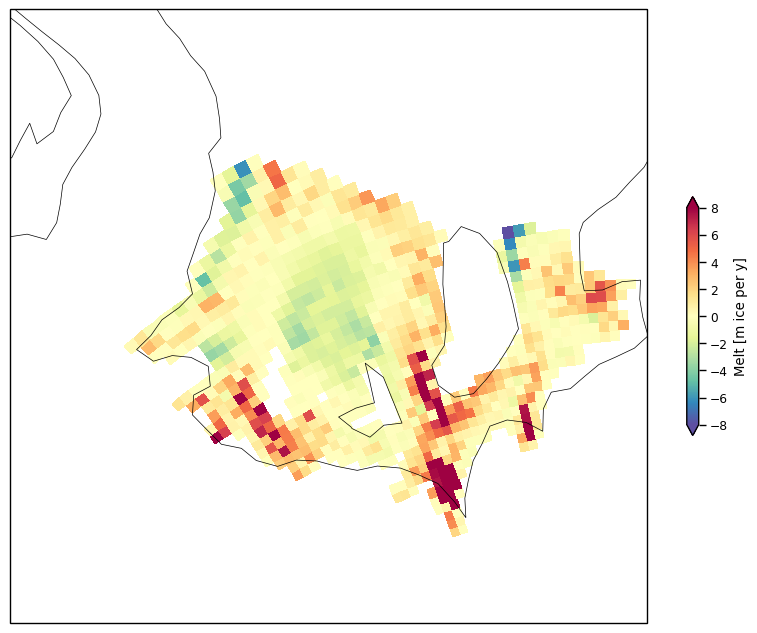

In [154]:
maps_melt(lon_melt_Wed,lat_melt_Wed,melt_open_Wed.where(melt_open_Wed != 0),'Melt [m ice per y]',mpl.cm.Spectral_r,'Filchner-Ronne','yes',lat_lim=-74)

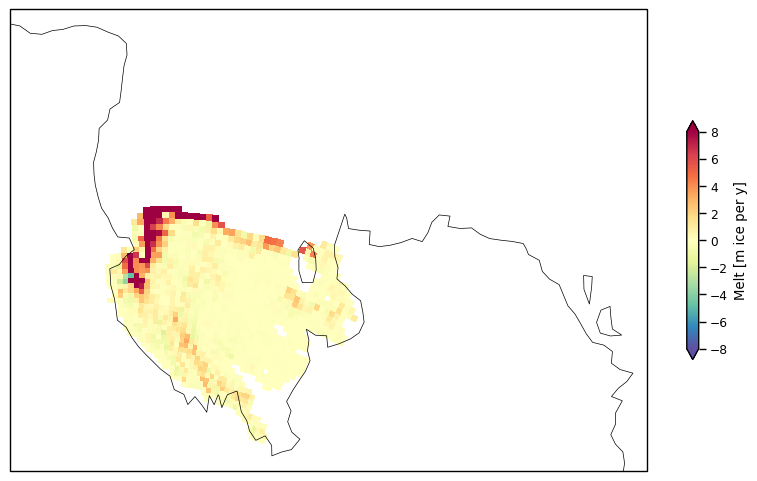

In [147]:
maps_melt(lon_melt_Ross,lat_melt_Ross,melt_open_Ross.where(melt_open_Ross != 0),'Melt [m ice per y]',mpl.cm.Spectral_r,'Ross','yes',lat_lim=-50)

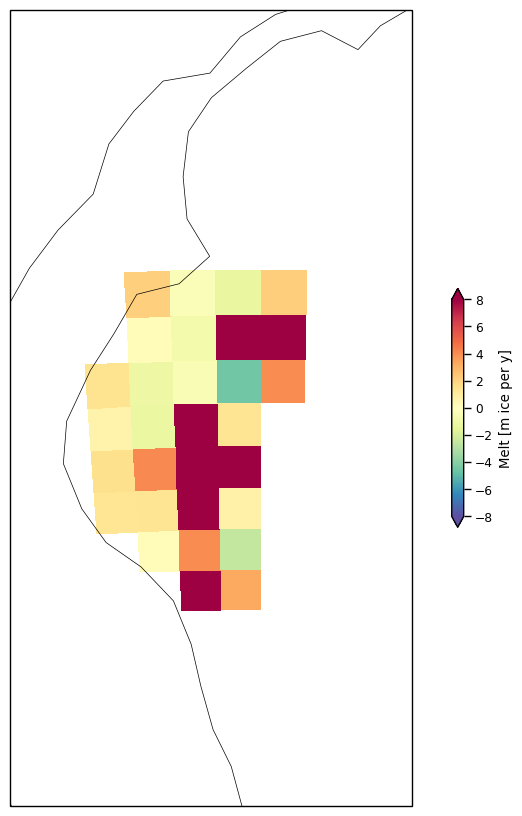

In [162]:
maps_melt(lon_melt_LarsenC,lat_melt_LarsenC,melt_open_LarsenC.where(melt_open_LarsenC != 0),'Melt [m ice per y]',mpl.cm.Spectral_r,'LarsenC','yes',lat_lim=-50)

In [158]:
melt_open_LarsenC

<xarray.DataArray 'iceshelf_cav' (y: 0, x: 0)>
array([], shape=(0, 0), dtype=float32)
Coordinates:
    nav_lat  (y, x) float32 
    nav_lon  (y, x) float32 
Dimensions without coordinates: y, x